In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(font_scale=2)
sns.set(style="white", color_codes=True)

In [2]:
from scipy import stats as spStats

# Define Parameters

In [3]:
parName = ['R1', 'R2']
parVal = np.array([1.270, 0.852])
parSig = np.array([0.026, 0.018])
nPar = parVal.shape[0]

In [4]:
a = np.zeros((nPar, nPar))
a[0, 1] = -0.715

corrM = a + a.T + np.identity(nPar)
print corrM

[[ 1.    -0.715]
 [-0.715  1.   ]]


In [5]:
covM = np.atleast_2d(parSig).T * corrM * parSig
print covM

[[ 0.000676   -0.00033462]
 [-0.00033462  0.000324  ]]


# Diagonalize the Covariance Matrix

In [6]:
eigVal, eigVec = np.linalg.eig(covM)
eigSig = np.sqrt(eigVal)

The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].

# Run Parameters Simulations

In [7]:
nSamples = 1000
eigSample = np.random.normal(loc=np.zeros(nPar), scale=eigSig, size=(nSamples,nPar))
parSample = np.dot(eigVec, eigSample.T).T + parVal
df = pd.DataFrame(parSample, columns=parName)

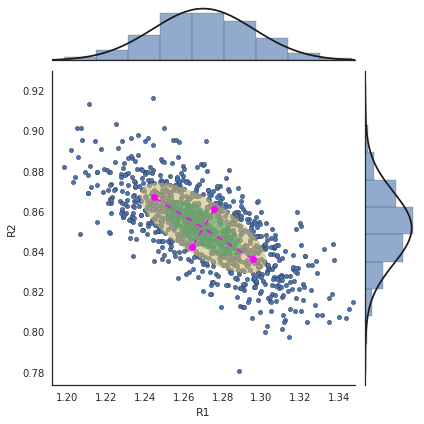

In [8]:
s = np.max(parSig[:2])
g = sns.JointGrid(x=parName[0], y=parName[1], data=df[df.columns[:2]], 
                  xlim=(parVal[0]-3*s, parVal[0]+3*s),
                  ylim=(parVal[1]-3*s, parVal[1]+3*s),
                 )
g = g.plot_joint(plt.scatter)

g.ax_marg_x.hist(df[parName[0]], normed=True, alpha=0.6)
g.ax_marg_y.hist(df[parName[1]], normed=True, orientation='horizontal', alpha=0.6)

xAux = np.arange(-4,4, 0.05)
yAux = np.exp(-np.square(xAux)/2.)/np.sqrt(2*np.pi)
g.ax_marg_x.plot(parSig[0]*xAux+parVal[0], yAux/parSig[0], color='k')
g.ax_marg_y.plot(yAux/parSig[1], parSig[1]*xAux+parVal[1], color='k')

colors = ['y', 'g']
for i in [2, 1]:
    alpha = spStats.norm.cdf(i) - spStats.norm.cdf(-i)
    c = np.sqrt(spStats.chi2.ppf(alpha, 2))
    
    ell = patches.Ellipse(parVal[:2], c*eigSig[0], c*eigSig[1], 
                          angle=np.arctan2(eigVec[1,0], eigVec[0,0])*180/np.pi,
                          alpha=0.6, color=colors[-i], 
                         )
    g.ax_joint.add_artist(ell)


d = np.column_stack((parVal + eigSig[0]*eigVec[:,0], parVal - eigSig[0]*eigVec[:,0]))
g.ax_joint.plot(d[0], d[1], 'o--', color='magenta')
d = np.column_stack((parVal + eigSig[1]*eigVec[:,1], parVal - eigSig[1]*eigVec[:,1]))
g.ax_joint.plot(d[0], d[1], 'o--', color='magenta')

Purple dashed lines are 1$\sigma$ variations of the eigenvectors, and the ellipsoides correspond to 1$\sigma$ (green) and 2$\sigma$ (yellow) probability.
It is ok that the green ellipsoide edge and the purple lines do not match. The n-ellipsoide is indeed defined as the area for which the probability of being outside is $n\sigma$.
Let the probability for a 1D Guassian variable to be within $n\sigma$ be :
\begin{equation}
P(|x-\mu| < n\sigma) = \alpha_n.
\end{equation}
Since the squared sum of uncorrelated gaussians is a $\chi^2$, the n-ellipsoide (in the eigenvector base) is defined as 
\begin{equation}
\frac{x^2}{\sigma_1^2} + \frac{y^2}{\sigma_2^2} < \Phi^{-1}(\alpha_n)
\end{equation}
where $\Phi^{-1}$ is the inverse of the cumulative function of a $\chi^2$ with 2 dof.
The ellipsoide has then semi-axis equal to $\sigma_1\sqrt{\Phi^{-1}(\alpha_n)}$ and $\sigma_2\sqrt{\Phi^{-1}(\alpha_n)}$ and a rotation angle equal to $\arctan(v_y/v_x)$, where $v$ is the first eigenvector.

# Weights MC

Let's consider the distribution of an observable $M$.
Let's assume that all the events weights for the central values are 1 (i.e. the events are generated with the central value) and some arbitrary function of M for the derivative of the weight w.r.t. the parameters of the FF ($R_1$, $R_2$).

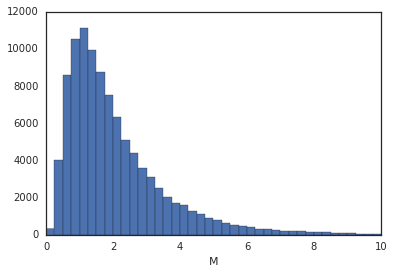

In [14]:
obsM = np.random.lognormal(mean=0.5, sigma=0.7, size=int(1e5))
xLims = (0, 10)
nBins = 40

plt.hist(obsM, bins=nBins, range=xLims)
plt.xlabel('M')
plt.ylabel('Events')
ymax = plt.ylim()[1]

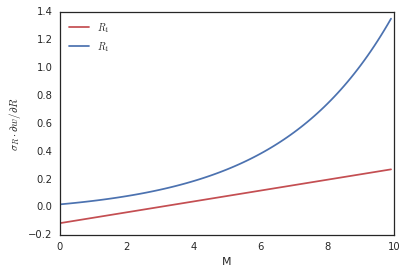

In [10]:
def dwdR1(M):
    return 5*0.3*(M-3)

def dwdR2(M):
#     return 5*3*np.exp(-0.7*M)-0.05
    return 4*np.exp(0.3*M)-3

xAux = np.arange(xLims[0], xLims[1], 0.1)
plt.plot(xAux, dwdR1(xAux)*parSig[0], 'r', label='$R_1$')
plt.plot(xAux, dwdR2(xAux)*parSig[1], 'b', label='$R_1$')
plt.legend(loc='best')
plt.xlabel('M')
plt.ylabel('$\sigma_{R} \cdot \partial w / \partial R$');

Multiplying by $\sigma$ give us the idea of how much the weight will be. I tuned the numbers in order to have order 1-10% variations.

In [11]:
def computeWeights(M, deltaR1=0, deltaR2=0):
    return 1 + dwdR1(M)*deltaR1 + dwdR2(M)*deltaR2

## Variations assuming independence

This approach is correct only when the correlation is 0. 
Wheather it overestimate or underestimate depends on the sign of the derivatives and the sign of the correlation.

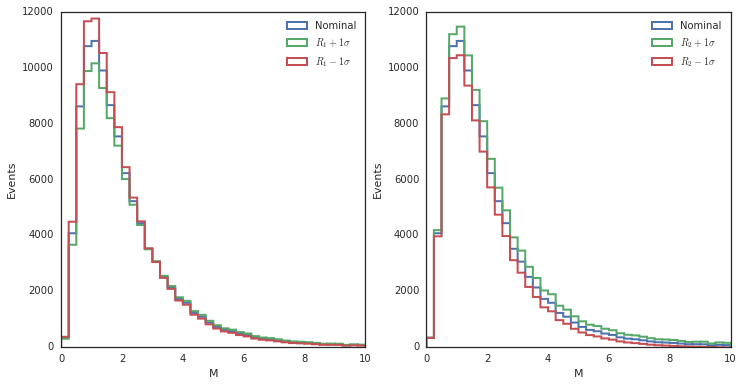

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
variations = np.diag(parSig)
for i, (varR1, varR2) in enumerate(variations):
    axs[i].hist(obsM, bins=nBins, range=xLims, histtype='step', lw=2, 
             label='Nominal')
    axs[i].hist(obsM, bins=nBins, range=xLims, histtype='step', lw=2, 
             weights=computeWeights(obsM, deltaR1=varR1, deltaR2=varR2),
             label='$R_{} +1\sigma$'.format(i+1))

    axs[i].hist(obsM, bins=nBins, range=xLims, histtype='step', lw=2, 
             weights=computeWeights(obsM, deltaR1=-varR1, deltaR2=-varR2),
             label='$R_{} -1\sigma$'.format(i+1))

    axs[i].legend(loc='best')
    axs[i].set_xlabel('M')
    axs[i].set_ylabel('Events')
    axs[i].set_ylim(0, ymax)

## Variation of Eigenvectors

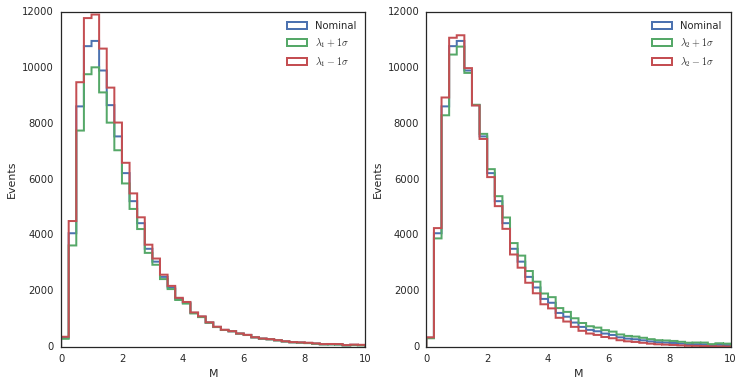

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
variations = eigSig*eigVec.T
for i, (varR1, varR2) in enumerate(variations):
    axs[i].hist(obsM, bins=nBins, range=xLims, histtype='step', lw=2, 
             label='Nominal')
    axs[i].hist(obsM, bins=nBins, range=xLims, histtype='step', lw=2, 
             weights=computeWeights(obsM, deltaR1=varR1, deltaR2=varR2),
             label='$\lambda_{} +1\sigma$'.format(i+1))

    axs[i].hist(obsM, bins=nBins, range=xLims, histtype='step', lw=2, 
             weights=computeWeights(obsM, deltaR1=-varR1, deltaR2=-varR2),
             label='$\lambda_{} -1\sigma$'.format(i+1))

    axs[i].legend(loc='best')
    axs[i].set_xlabel('M')
    axs[i].set_ylabel('Events')
    axs[i].set_ylim(0, ymax)

## MC trials

In [50]:
bContCentral, bEdges = np.histogram(obsM, bins=nBins, range=xLims)
bContDev = np.zeros((parSample.shape[0], bContCentral.shape[0]))
for i, (varR1, varR2) in enumerate(parSample - parVal):
    bCont, _ = np.histogram(obsM, bins=nBins, range=xLims, 
                            weights=computeWeights(obsM, deltaR1=varR1, deltaR2=varR2)
                           )
    bContDev[i] = bCont
bContDevDown = np.percentile(bContDev.T, 100*spStats.norm.cdf(-1), axis=1)
bContDevUp = np.percentile(bContDev.T, 100*spStats.norm.cdf(1), axis=1)

(0, 12000.0)

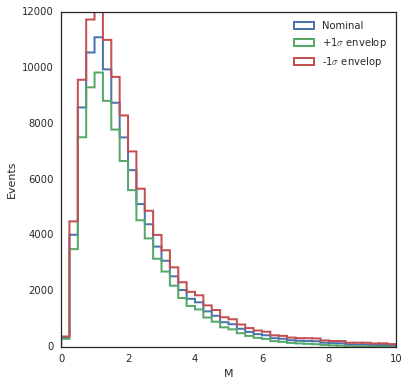

In [51]:
fig = plt.figure(figsize=(6,6))
plt.hist(obsM, bins=nBins, range=xLims, histtype='step', lw=2, label='Nominal')

xAux = 0.5*(bEdges[:-1] + bEdges[1:])
plt.hist(xAux, bins=nBins, range=xLims, 
         weights=bContDevDown,
         histtype='step', lw=2, label='+1$\sigma$ envelop')
plt.hist(xAux, bins=nBins, range=xLims, 
         weights=bContDevUp,
         histtype='step', lw=2, label='-1$\sigma$ envelop')
plt.legend(loc='best')
plt.xlabel('M')
plt.ylabel('Events')
plt.ylim(0, ymax)

With this approach you get a band but you don't know which are the available variations inside the band because with the MC the information of the degrees of freedom and how they impact the histogram is lost.
There is no proper way to use this in Combine IMO because the up and down histogram do not reflect the variation of any parameter but just a stat. envelop.